In [1]:
import QuantumRingsLib
from QuantumRingsLib import QuantumRegister, AncillaRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor
from QuantumRingsLib import JobStatus
from matplotlib import pyplot as plt
import numpy as np
import math

provider = QuantumRingsProvider(token='rings-200.VVVgLQZDn1aZXtV98uAg52ZpHC41mWJL', name='Ruotong.Yang21@student.xjtlu.edu.cn')
backend = provider.get_backend("scarlet_quantum_rings")
shots = 2048

provider.active_account()

{'name': 'Ruotong.Yang21@student.xjtlu.edu.cn',
 'token': 'rings-200.VVVgLQZDn1aZXtV98uAg52ZpHC41mWJL',
 'max_qubits': '200'}

In [2]:
def iqft_cct(qc, b, n):
    """
    The inverse QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cu1(  -math.pi / 2** ( i -j + 1 ), b[j - 1], b[i])
        # the H transform should be done after the rotations
        qc.h(b[i])
    qc.barrier()
    return

def plot_histogram (counts, title=""):
    """
    Plots the histogram of the counts

    Args:

        counts (dict):
            The dictionary containing the counts of states

        titles (str):
            A title for the graph.

    Returns:
        None

    """
    fig, ax = plt.subplots(figsize =(10, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]

    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)

    plt.bar(unique, bin_counts)

    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    # Show plot
    plt.title(title)
    plt.show()
    return

In [4]:
# Shor’s algorithm to factorize 15 using 2^x mod 15.
numberofqubits = 7
shots = 1024

q = QuantumRegister(numberofqubits , 'q')
c = ClassicalRegister(4 , 'c')
qc = QuantumCircuit(q, c)

# Initialize source and target registers
qc.h(0)
qc.h(1)
qc.h(2)
qc.x(6)
qc.barrier()

# Modular exponentiation 2^x mod 15
qc.cx(q[2],q[5])
qc.cx(q[2],q[6])
qc.cx(q[1],q[4])
qc.cx(q[1],q[6])
qc.ccx(q[1],q[2],q[3])
qc.ccx(q[1],q[2],q[4])
qc.ccx(q[1],q[2],q[5])
qc.ccx(q[1],q[2],q[6]) #
qc.barrier()

# IQFT. Refer to implementation from earlier examples
iqft_cct (qc, q, 4)

# Measure
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])
qc.measure(q[3], c[3])

# Draw the circuit
qc.draw('mpl')
plt.show()

       ┌───┐ ╎                                          ╎ ┌───┐               »
q[0]: ■┤ H ├─╎──────────────────────────────────────────╎─┤ H ├───────■───────»
       ├───┤ ╎                                          ╎ └───┘┌──────┴──────┐»
q[1]: ■┤ H ├─╎─────────────■────■────■────■────■────■───╎──────┤ U1(-pi/2)   ├»
       ├───┤ ╎             │    │    │    │    │    │   ╎      └─────────────┘»
q[2]: ■┤ H ├─╎───■────■────│────│────■────■────■────■───╎─────────────────────»
       └───┘ ╎   │    │    │    │  ┌─┴─┐  │    │    │   ╎                     »
q[3]: ■──────╎───│────│────│────│──┤ X ├──│────│────│───╎─────────────────────»
             ╎   │    │  ┌─┴─┐  │  └───┘┌─┴─┐  │    │   ╎                     »
q[4]: ■──────╎───│────│──┤ X ├──│───────┤ X ├──│────│───╎─────────────────────»
             ╎ ┌─┴─┐  │  └───┘  │       └───┘┌─┴─┐  │   ╎                     »
q[5]: ■──────╎─┤ X ├──│─────────│────────────┤ X ├──│───╎─────────────────────»
       ┌───┐ ╎ └───┘┌─┴─┐     ┌─┴─┐     

Job Running
Job Done.
Ending Job Monitor


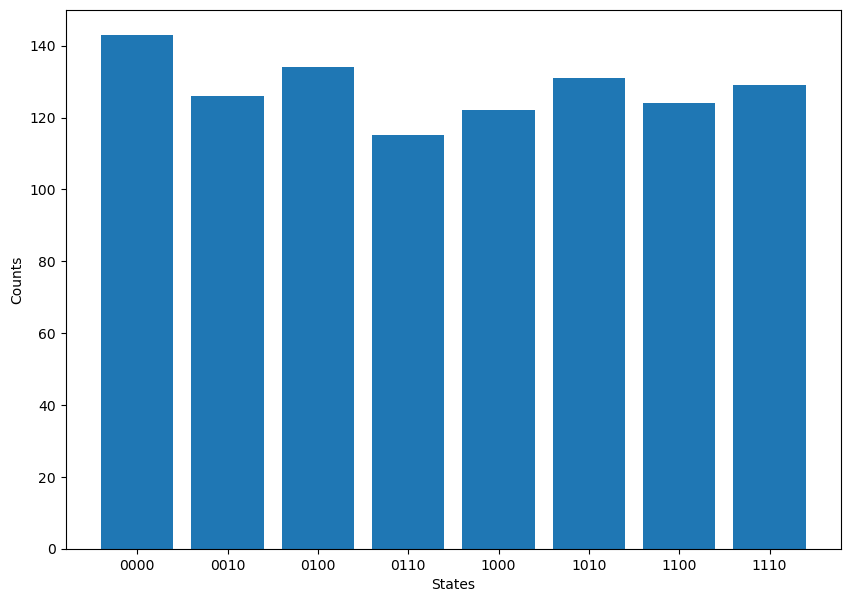

In [5]:
# Execute the circuit
job = backend.run(qc, shots=shots)
job_monitor(job)
result = job.result()
counts = result.get_counts()

# visualize
plot_histogram(counts)

#clean up
del q, c, qc
del result
del job